<a href="https://colab.research.google.com/github/martatolos/eae-dsaa-2025/blob/main/nlp_retrieval_augmented_generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Retrieval Augmented Generation

> Goal of the session:
>
> - Implement essential pipeline to generate answers with Retrieval Augmented Generation (RAG).
>
>Scope of the session
>
> - We will walk through the basic components required in RAG.
> - We will use an instruction tuned LLM.

## 1. RAG Pipeline

First, let's review the pipeline that we explained during the class.

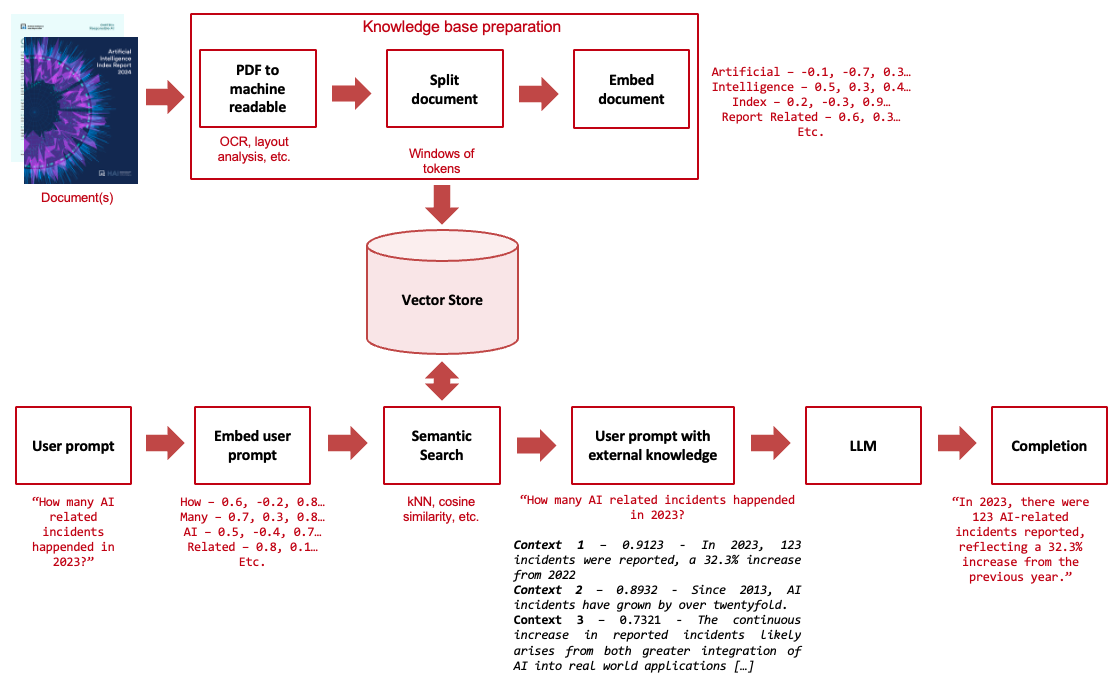

## 2. Setup

### Dependencies

- ``chromadb`` 1.0.5
- ``ipython``
- ``numpy`` 2.0.2
- ``langchain`` 0.3.23
- ``langchain-community`` 0.3.21
- ``langchain-openai`` 0.3.14
- ``openai`` 1.75.0
- ``pathlib``
- ``pypdf`` 5.4.0
- ``python-dotenv``
- ``requests``
- ``tiktoken`` 0.9.0

In [ ]:
%pip install chromadb==1.0.5 ipython numpy==2.0.2 langchain==0.3.23 langchain-community==0.3.21 \
    langchain-openai==0.3.14 pathlib openai==1.75.0 pypdf==5.4.0 python-dotenv requests tiktoken==0.9.0

### Imports

In [ ]:
import json
import os
import dotenv
import numpy as np
import requests

from pathlib import Path
from IPython.display import Markdown, display
from langchain.document_loaders import PyPDFLoader
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from openai import OpenAI

### Download AI Index Report 2025

For illustrating RAG systems, we'll leverage the [HAI AI index report 2025](https://hai-production.s3.amazonaws.com/files/hai_ai_index_report_2025.pdf) as proprietary knowledge source.

In [ ]:
def download_file(url: str, output_file: str) -> None:
    """
    Download a file from a URL.
    :param url: URL to download
    :param output_file: Path to output file
    """
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an exception for HTTP errors

        with open(output_file, "wb") as file:
            for chunk in response.iter_content(chunk_size=8192):
                if chunk:  # filter out keep-alive chunks
                    file.write(chunk)

        print(f"File downloaded successfully and saved as '{output_file}'.")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading file: {e}")
        raise e

In [ ]:
# Download the AI index file
download_file(
    url="https://hai-production.s3.amazonaws.com/files/hai_ai_index_report_2025.pdf",
    output_file="hai_ai_index_report_2025.pdf",
)

In [ ]:
# Set the source document location
source_document = Path("hai_ai_index_report_2025.pdf")

### API Key

Add your OpenAI API key in the cell below or create a `.env` file in the same directory as this notebook with the following content:

```
OPENAI_API_KEY=your_openai_api_key
```

> [!Warning]
> Make sure you do not save or commit the file without removing your API key. If that happens, reset the key so that it is not compromised.

In [ ]:
open_ai_key = None  # Add your OpenAI API key here
dotenv.load_dotenv()
os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY", open_ai_key)

### Helper functions

Next, we will create a function that we will use in today's activity and in the next NLP lecture as well. We will use [chat completions endpoint](https://platform.openai.com/docs/guides/text-generation/chat-completions-api).

Also most LLMs use markdown format to in their output. We will use ``render_markdown`` function to show the outputs we get in a more readable format.

In [ ]:
def get_completion(prompt: str, model_name: str = "gpt-4.1-nano") -> str:
    """Get the completion from OpenAI API.

    :param prompt: Prompt to be sent to the model.
    :param model_name: Name of the model which will be used.
        Check https://platform.openai.com/docs/models to get an updated list.
        Defaults to "gpt-4.1-nano"
    :return: Completion from the model.
    """
    client = OpenAI()
    response = client.responses.create(
        model=model_name,
        input=prompt
    )
    return response.output[0].content[0].text


def render_markdown(text: str) -> None:
    """Render the text as markdown.

    :param text: Text to be rendered.
    """
    display(Markdown(text))


def show_completion(prompt: str, model_name: str = "gpt-4.1-nano") -> None:
    """Get the completion from OpenAI API and render it as markdown.

    :param prompt: Prompt to be sent to the model.
    :param model_name: Name of the model which will be used.
        Check https://platform.openai.com/docs/models to get an updated list.
        Defaults to "gpt-4.1-nano"
    """
    completion = get_completion(prompt, model_name)
    render_markdown(completion)

In [ ]:
prompt = "Tell me a joke"
show_completion(prompt)

## 3. Knowledge Base Preparation

Steps:

1. Load source document
2. Split document
3. Embed document splits
4. Store document splits embeddings in Vector Store

### Parse document

In [ ]:
loader = PyPDFLoader(source_document)
doc = loader.load()

### Split document

- Document is split into windows of tokens: 1500 tokens.
- The splitting is carry out with tokens chunks overlapping (150 tokens overlapping) to capture the semantic of the context and not to miss any context in the splitting.

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1500, chunk_overlap=150)

In [ ]:
splits = text_splitter.split_documents(doc)

In [ ]:
len(splits)

See how a chunk looks like:

In [ ]:
splits[0]

### Embed document splits

Encoding text into embeddings is a required step for semantic comparison, which is a process required for enriching prompts with external document sources (i.e. the most similar splits given a user instruction). In the lecture we covered multiple approaches how to embed text.

In this activity, we'll leverage one of Open AIs embedding models, i.e., `text-embedding-3-small`. Refer to [https://platform.openai.com/docs/guides/embeddings](https://platform.openai.com/docs/guides/embeddings) for more details.

In [ ]:
embedding = OpenAIEmbeddings(model="text-embedding-3-small")

Before embedding the source document, let's stop and understand embedding and semantic search with dot product (i.e. cosine similarity) work with some examples.

In [ ]:
# examples
sentence1 = "i like dogs"
sentence2 = "i like canines"
sentence3 = "the weather is ugly outside"

In [ ]:
# embed examples
embedding1 = embedding.embed_query(sentence1)
embedding2 = embedding.embed_query(sentence2)
embedding3 = embedding.embed_query(sentence3)

An embedding is a vector representation of a text. In the next cell you can see how the embedding looks like.

In [ ]:
print(f"embedding1: {embedding1}")

In [ ]:
# dot product on sentence 1 and 2
np.dot(embedding1, embedding2)

In [ ]:
# dot product on sentence 1 and 3
np.dot(embedding1, embedding3)

In [ ]:
# dot product on sentence 2 and 3
np.dot(embedding2, embedding3)

### Store embeddings in Vector Store

The Vector Store used is Chroma DB.

A vector store, also known as a vector database, is a specialized database designed to efficiently store and query high-dimensional vectors, typically embeddings generated from data like text, images, or audio.

Here's a simplified overview of how it works:

1.  **Embedding Generation:** Before storing data, it's converted into numerical vector representations (embeddings) using an embedding model. These embeddings capture the semantic meaning or features of the original data. For example, text documents are split into chunks, and each chunk is transformed into an embedding vector.

2.  **Indexing:** The vector store indexes these high-dimensional vectors using specialized algorithms (like HNSW, IVF, or LSH). These indexes allow for fast searching over potentially millions or billions of vectors. The goal is to quickly find vectors that are "close" to a given query vector in the high-dimensional space.

4. **Storage:** The vectors and their associated metadata (like the original text chunk or document ID) are stored.

5. **Querying (Similarity Search):** When a query comes in (e.g., a user question), it's first converted into an embedding vector using the *same* embedding model used for the stored data. The vector store then uses its index to efficiently find the vectors in the database that are most similar to the query vector, typically based on metrics like cosine similarity or Euclidean distance.

6. **Retrieval:** The vector store returns the most similar vectors (and their associated metadata) to the query vector. In a RAG system, this retrieved information (e.g., relevant document chunks) is then used to augment the prompt for a large language model.

In [ ]:
# store embeddings
vector_db = Chroma.from_documents(
    documents=splits,
    embedding=embedding,
)

## 3. Similarity Search

Once the document has been pre-processed, transformed into embeddings and stored in a vector store, all the pieces are in place to run semantic search.

How does it work? We are going to use the source document to perform Question-Answering, and we are going to query the LLM to answer our questions with information of the source document pre-processed.

Steps:

1. Create prompt
2. Embed prompt
3. Semantic search

Scope:

- Similarity metric: cosine similarity

In [ ]:
user_query = "Tell me about AI incidents reported in 2024?"

In [ ]:
docs = vector_db.similarity_search(user_query, k=10)
len(docs)

In [ ]:
# store most similar contexts in a string (LLM parses strings)
contexts = ""
for doc in docs:
    contexts += doc.page_content
    contexts += "\n\n"
render_markdown(contexts)

## 4. Generate completion with knowledge base sources

Once the most similar contexts of the document given a user query are retrieved, we can use them to generate a completion with these sources (i.e., non-parametic information).

Steps:
1. Inject knowledge base contexts to user query
2. Query the LLM with the prompt enriched

Now, we will use OpenAI SDK. Therefore, we will need to load the key using the SDK.

In [ ]:
# create prompt with knowledge base contexts
prompt = f"""
<contexts>
{contexts}
<contexts>

<query>
{user_query}
<query>

You are a helpful assistant expert on Artificial Intelligence. \
You can use GitHub-flavored Markdown to format your answer. \
Answer the user question delimited by tags <query>. \
Your answer should only use information provided in the list of contexts delimited by tags <contexts>.
"""

print(prompt)

In [ ]:
show_completion(prompt)

You can compare the previous response with the one you would get without the added context.

In [ ]:
prompt = f"""
<query>
{user_query}
<query>

You are a helpful assistant expert on Artificial Intelligence. \
You can use GitHub-flavored Markdown to format your answer. \
Answer the user question delimited by tags <query>.
"""

show_completion(prompt)

## Bonus: Dynamic Function Calling

We just saw how to use the LLM to generate completions with knowledge base sources. Now, we will see how to use the LLM can get access to tools and use them directly to answer the user query.

Function calling allows Large Language Models (LLMs) to interact with external tools and APIs. Instead of just generating text, the LLM can identify when a user's request requires information or actions beyond its internal knowledge.

Here's how it typically works:

1.  **Tool Definition:** You define a set of available tools (functions) that the LLM can use, including their names, descriptions, and expected input parameters (often using JSON schema).
2.  **User Request:** A user sends a prompt to the LLM.
3.  **Tool Identification:** The LLM analyzes the prompt and, based on the descriptions of the available tools, determines if any tool can help fulfill the request.
4.  **Function Call Generation:** If a suitable tool is identified, the LLM doesn't directly execute it. Instead, it generates a structured output (usually JSON) indicating the name of the function to call and the arguments extracted from the user's prompt.
5.  **Execution:** Your application code receives this structured output, parses it, and executes the actual function/API call with the provided arguments.
6.  **Result Submission:** The result obtained from executing the function is sent back to the LLM as part of the ongoing conversation.
7.  **Final Response Generation:** The LLM uses the function's result, along with the original prompt and conversation history, to generate a final, informed response for the user.

This enables LLMs to:

*   Access real-time information (e.g., weather, stock prices).
*   Interact with databases or internal systems.
*   Perform actions in the real world (e.g., send emails, book appointments).
*   Utilize specialized calculators or data analysis tools.

We will give the LLM access to a function that can be used get real-time weather.

First, we will ask about the weather in a specific location, initially without the function. Then, we will ask the same question with the function available. The LLM will be able to call the function and get the real-time weather information. 

In [ ]:
prompt = "What is the weather in Barcelona?"

show_completion(prompt)

First we implement a function to get weather information.

In [ ]:
def get_weather(latitude: float, longitude: float) -> float:
    """Get the current temperature for a given latitude and longitude.

    :param latitude: Latitude of the location.
    :param longitude: Longitude of the location.
    :return: Current temperature in Celsius.
    """
    response = requests.get(
        f"https://api.open-meteo.com/v1/forecast?latitude={latitude}&longitude={longitude}&current=temperature_2m,wind_speed_10m&hourly=temperature_2m,relative_humidity_2m,wind_speed_10m"
    )
    data = response.json()
    return data["current"]["temperature_2m"]


print(get_weather(41.3851, 2.1734))  # Barcelona coordinates

Now we implement a function that will call the LLM with the function available. The LLM will be able to call the function and get the real-time weather information.

In [ ]:
def call_llm(messages: list[dict[str, str]], model_name: str = "gpt-4.1-nano") -> str:
    """Call the LLM with the provided prompt.

    :param prompt: Prompt to be sent to the model.
    :param model_name: Name of the model which will be used.
        Check https://platform.openai.com/docs/models to get an updated list.
        Defaults to "gpt-4o-mini"
    :return: Completion from the model.
    """
    client = OpenAI()

    # We define the function that allows the llm to call the weather function.
    tools = [
        {
            "type": "function",
            "name": "get_weather",
            "description": "Get current temperature for provided coordinates in celsius.",
            "parameters": {
                "type": "object",
                "properties": {"latitude": {"type": "number"}, "longitude": {"type": "number"}},
                "required": ["latitude", "longitude"],
                "additionalProperties": False,
            },
            "strict": True,
        }
    ]

    return client.responses.create(
        model=model_name,
        input=messages,
        tools=tools,
    )

We call now the improved LLM.

In [ ]:
messages = [{"role": "user", "content": prompt}]

tool_call = call_llm(messages).output[0]

print(tool_call)

Load the function arguments, call the function and call the LLM with the function result.

In [ ]:
args = json.loads(tool_call.arguments)

temperature = get_weather(args["latitude"], args["longitude"])

messages.append(tool_call)  # append model's function call message
messages.append(
    {  # append result message
        "type": "function_call_output",
        "call_id": tool_call.call_id,
        "output": str(temperature),
    }
)

final_response = call_llm(messages)
render_markdown(final_response.output_text)